## Testing AUCell cell-level pathway activity scoring

In [39]:
from pathlib import Path
import os
import decoupler
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import scanpy as sc

In [40]:
# set GOI

GOI = 'CASP8'

In [41]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

adata = sc.read_h5ad('data/output/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [42]:
# get reactome pathway data

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [43]:
reactome = gmt_to_decoupler("data/c2.cp.reactome.v2023.2.Hs.symbols.gmt")
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 300)]
reactome = reactome[reactome.geneset.isin(gsea_genesets)]

In [55]:
def clean_target_genes(row):
    return eval(row['TargetGenes'])

regulon = pd.read_csv(os.path.join(wdir, "SCENICfiles/reg.csv"))
regulon.apply(clean_target_genes, axis=1)

def get_regulon_genes(TF): # give TF name as string, e.g. 'KLF5'

    all_targets = regulon[regulon['TF'] == TF]['TargetGenes']
    df = pd.DataFrame()
    for i in all_targets:
        i = eval(i)
        df = pd.concat([df, pd.DataFrame(i)], axis=0)
        
    df = df.drop_duplicates()
    df = df.rename(columns={0: 'target', 1: 'importance'})
    df = df.sort_values(by='importance', ascending=False)
    df['TF'] = TF + "_REGULON"
    return df # returns a dataframe with all target genes and importance scores for a given TF

def get_regulon_genesets(regulon):
    df = pd.DataFrame()
    for TF in regulon['TF'].unique():
        df = pd.concat([df, get_regulon_genes(TF)], axis=0)
    df = df.drop(columns='importance')
    df = df.rename(columns={'target': 'genesymbol', 'TF': 'geneset'})
    # filter out geneset sizes that are too large or too small
    #geneset_size = df.groupby("geneset").size()
    #gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 1000)] # this may filter out some regulons with GOI in target genes...? 
    #df = df[df.geneset.isin(gsea_genesets)]
    df = df.reset_index(drop=True)
    return df

regulon_genesets = get_regulon_genesets(regulon)

In [56]:
regulon_genesets.value_counts('geneset')

geneset
ELF3_REGULON       3538
EHF_REGULON        2377
KLF5_REGULON       2230
KLF4_REGULON       1354
YY1_REGULON        1274
                   ... 
ZNF644_REGULON        3
ISL2_REGULON          3
ZSCAN5A_REGULON       3
ZNF695_REGULON        2
HOXD10_REGULON        2
Name: count, Length: 382, dtype: int64

In [45]:
geneset_df = pd.concat([reactome, regulon_genesets], axis=0)
geneset_df = geneset_df.reset_index(drop=True)
geneset_df

,geneset,genesymbol
0,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA10
1,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA12
2,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA2
3,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA3
4,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA4
...,...,...
102322,ZNF518A_REGULON,SLC25A10
102323,ZNF518A_REGULON,ZFP3
102324,ZNF518A_REGULON,SCPEP1
102325,ZNF518A_REGULON,CBLN2


In [46]:
# run AUCell on REACTOME pathway and regulon genesets

decoupler.run_aucell(
    adata,
    geneset_df,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

In [47]:
# correlation between each pathways AUCell score and CASP8 expression (ONLY GENESETS AFTER FILTERING!!)
pathways_goi = geneset_df[(geneset_df['genesymbol'] == GOI)]

# get the AUCell scores for the genes in the pathway
goi_expression = adata.to_df()[GOI]

def calc_correlation(column): # Spearman
    return column.corr(goi_expression, method='spearman')


pathways_goi.loc[:, 'correlation'] = adata.obsm['aucell_estimate'][pathways_goi['geneset']].apply(calc_correlation).values
pathways_goi = pathways_goi.sort_values('correlation', key=pd.Series.abs, ascending=False)
pathways_goi

,geneset,genesymbol,correlation
100068,MSC_REGULON,CASP8,0.236131
43485,REACTOME_REGULATION_OF_NF_KAPPA_B_SIGNALING,CASP8,0.156916
83049,TFDP1_REGULON,CASP8,0.142626
34222,REACTOME_NOD1_2_SIGNALING_PATHWAY,CASP8,0.129718
98613,IKZF3_REGULON,CASP8,0.129300
26770,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,CASP8,0.125933
35373,REACTOME_NUCLEOTIDE_BINDING_DOMAIN_LEUCINE_RIC...,CASP8,0.117351
70945,IKZF1_REGULON,CASP8,0.114201
57997,REACTOME_TNF_SIGNALING,CASP8,0.111905
57823,REACTOME_TNFR1_INDUCED_PROAPOPTOTIC_SIGNALING,CASP8,0.111356


In [48]:
# print gene set of specific regulon
ROI = pathways_goi.iloc[0]['geneset']
ROI = 'PPARG_REGULON'
print ('%s' % ' '.join(map(str, geneset_df[geneset_df['geneset'] == ROI]['genesymbol'].values)))

SLC26A3 KRT20 NR1H4 AKR1B10 MIR210HG BCO1 RAG1 CKB SULT2B1 TM4SF20 TMIGD1 KRT19 TSPAN1 C11orf86 SLC25A23 SULT1B1 HKDC1 HRCT1 PTPRR SLC51B CA13 SLC51A SULT1A2 C4orf48 C4BPB SLC26A2 SLC16A5 TMEM37 FXYD3 MMP28 BCAS3 FSIP2 SDCBP2 LEAP2 SLC2A9 GFI1B ETHE1 GCNT3 ALDOB INPP5J RHOF CPTP ORAI3 TPRN ZNF335 SLC9A1 VILL OSBPL7 CDHR5 MYZAP OAS1 NOXA1 CDC42BPG MEP1A PPARG TDP2 CCDC28A CDKN2B NAT2 CA2 EDN3 ITGB4 ZFYVE28 MS4A12 PRAP1 SFN TAX1BP3 PSORS1C1 S100A6 CGN XDH HSD17B2 PAQR8 CLDN23 GDPD3 CA1 DIO3OS HHLA2 SHROOM1 ZNF432 C3orf70 TTC13 SLC6A9 SMPD1 SLC27A3 PQLC2 PCK1 PDE6A AK8 IL2RG STAP2 SRI CCL23 VSIG2 PLA2G6 LASP1 CLCN2 KALRN CLDN8 VLDLR CNIH3 PRRT3 PKIB MOGAT3 RETSAT TMEM92 TMBIM1 EPHX2 TTC39A DEFB1 GRAMD4 CD177 FABP2 HPGD RSPH1 DHRS9 SPINT1 SLC36A1 PLCD1 KLHL9 ADIRF TMC4 CLPTM1 GNA11 ADPRHL1 DLGAP1-AS2 PLAC8 FREM1 SLC6A8 LDHD ERCC5 FAM50B FLNB ART3 PPARD KBTBD11 CTSE LINC01559 CEACAM1 CYP2B6 SLC22A18 KRT8 GOLT1A ZNF837 ACAA1 LRRN2 AZIN2 ERBB2 LYPD8 PKD1L1 SCIN ZNF527 YIPF1 PRR15 ABCC3 PHYKPL

/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


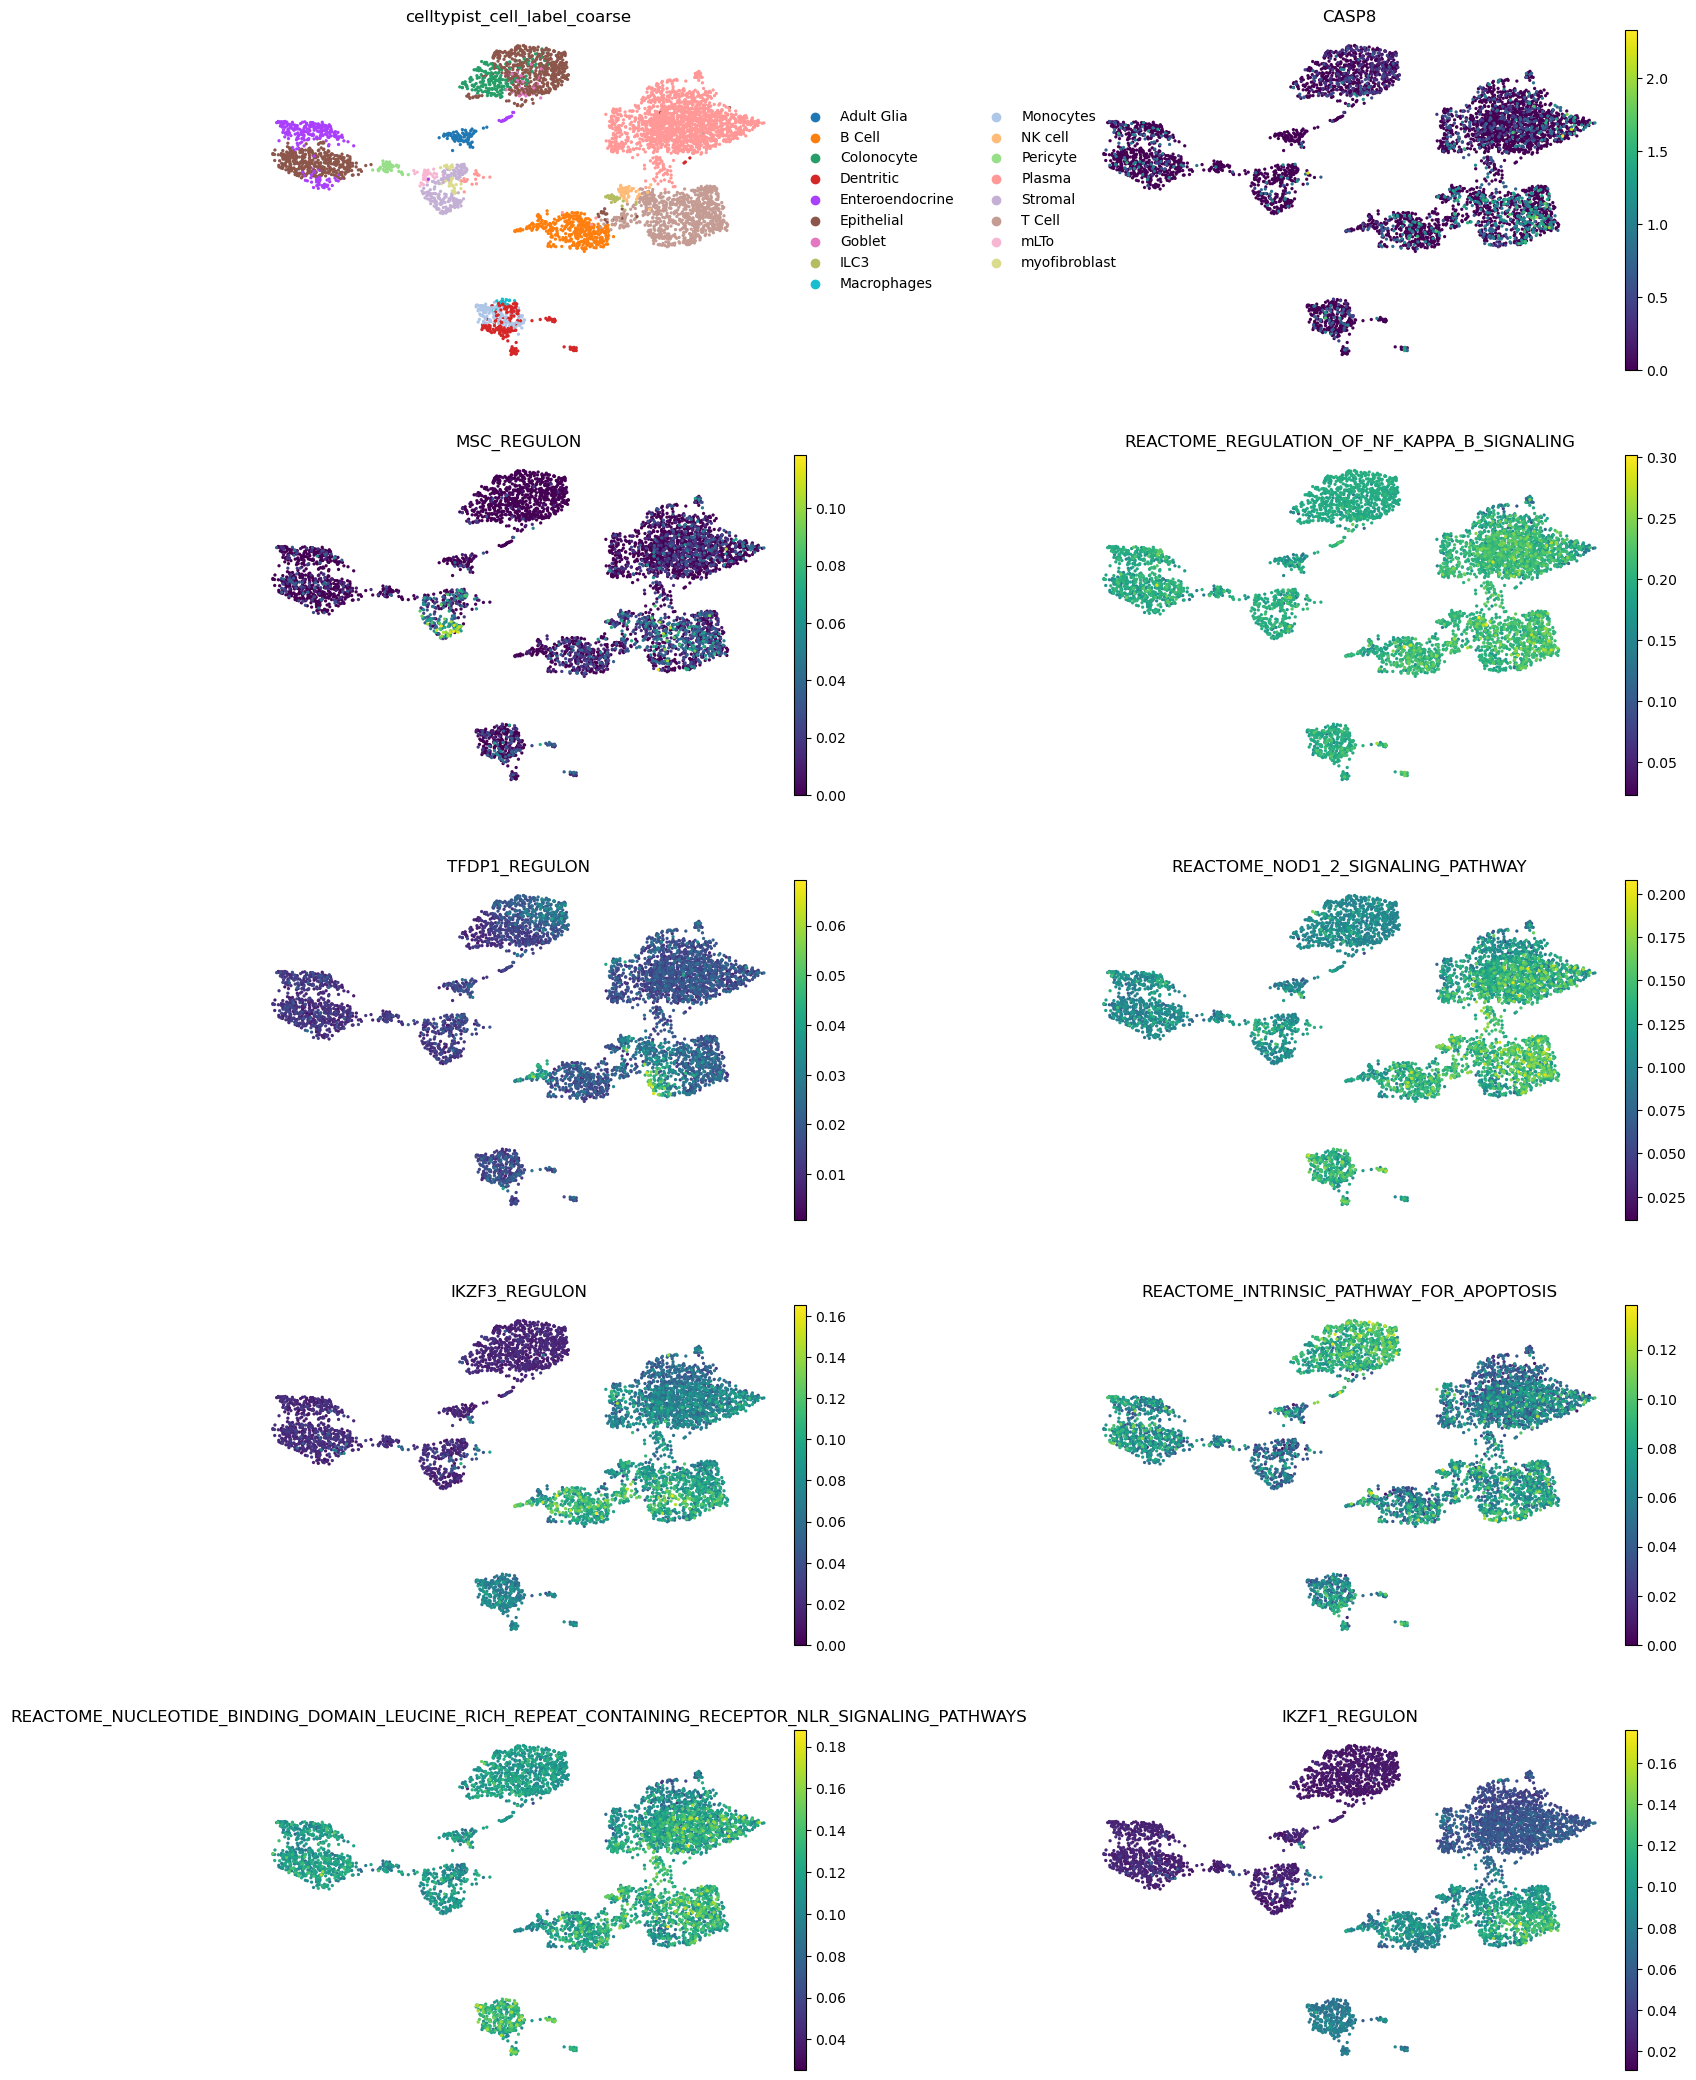

In [51]:
top_pathways = list(pathways_goi['geneset'].values[:8])
adata.obs[top_pathways] = adata.obsm["aucell_estimate"][top_pathways]

sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", GOI] + top_pathways,
    frameon=False,
    ncols=2,
    wspace=0.4,
)

# Regulon-level gene set enrichment analysis

In [50]:
# g:Profiler g:GOSt analysis? 